# Analysis of the substructures: Metallicity, CMD, 3D Plot

In [1]:
import os
import csv
import vaex
import matplotlib
import pylab as p
from numpy import *
import pandas as pd
import subprocess as sub
from matplotlib.backends.backend_pdf import PdfPages

## Matching the 2 datasets (original TGASxRAVE and output Rockstar)

In [5]:
# the original dataset (ds = dataset of the original tgas-rave)
tmp_data = '/net/virgo01/data/users/virgini/rockstar/RC3/data/data_6d_cut'
ds = vaex.open(tmp_data)

# the output from rockstar (dp = dataset of particles)
tmp_part = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b10-f90-n10-t70-particles'
hdr_part = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'rs_id', 'as_int_id', 'int_id', 'ext_id']
dp = vaex.from_ascii(tmp_part, names=hdr_part)

# convert the data from integer into float
dp.add_column(name='as_int_id', data=dp.data.as_int_id.astype(float))
dp.add_column(name='int_id', data=dp.data.int_id.astype(float))
dp.add_column(name='ext_id', data=dp.data.ext_id.astype(float))

# select only the real substructures
dp.select('as_int_id == int_id', name='real')
dp_sel = dp.to_copy(selection='real')

# join the 2 datasets
ds._join('rockstar_id', dp_sel, 'rs_id', column_names=['as_int_id', 'int_id', 'ext_id'])

In [ ]:
n_sub = int(max(ds.data.ext_id[~isnan(ds.data.ext_id)]))
 
for n in range(n_sub):
    ds.select('ext_id == %s' %n, name='sub')
    print(n, ds.evaluate('l', selection='sub').mean(), ds.evaluate('b', selection='sub').mean())

In [656]:
# How many stars without metallicity data?

print('Total of stars = %s' %len(ds.data.Met_K))
print('Stars without metallicity data = %s' %(len(ds.data.Met_K) - len(ds.data.Met_K[~isnan(ds.data.Met_K)])))
print('Stars within substructures = %s' %len(ds.data.ext_id[~isnan(ds.data.ext_id)]))

Total of stars = 108916
Stars without metallicity data = 2133
Stars within substructures = 69631


## Matching the 2 datasets (original TGASxRAVE and high confidence substructures)

In [36]:
# the original dataset (ds = dataset of the original tgas-rave)
tmp_data = '/net/virgo01/data/users/virgini/rockstar/RC3/data/data_6d_cut'
ds = vaex.open(tmp_data)

# the output from rockstar (dh = dataset of high confidence substructures)
tmp_part = '/net/virgo01/data/users/virgini/rockstar/RC3/output/vary-fb-10/high-confidence'
hdr_part = ['sub_id', 'p_id']
dh = vaex.from_ascii(tmp_part, names=hdr_part)

In [44]:
# join the 2 datasets
ds._join('rockstar_id', dh, 'p_id', column_names=['sub_id'])

## See how they look on the sky

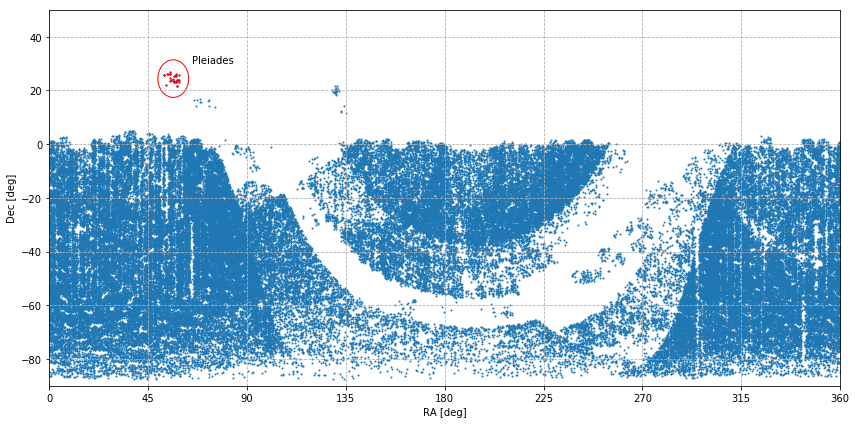

In [55]:
fig = p.figure(figsize=(12,6))
ds.scatter('ra', 'dec', s=1, length_check=False)
ds.scatter('ra', 'dec', s=1, c='red', selection='(ra < 100) & (dec > 20)')
p.gca().add_patch(p.Circle((56.43,24.41), radius=7, ec='red', fc='none'))
p.text(65, 30, 'Pleiades')
p.grid(linestyle='dashed')
p.xticks([0, 45, 90, 135, 180, 225, 270, 315, 360])
p.xlabel('RA [deg]'), p.ylabel('Dec [deg]')
p.xlim(0,360), p.ylim(-90,50)
p.tight_layout()
p.show()
tmp = '/net/virgo01/data/users/virgini/rockstar/RC3/output/vary-fb-np10/sky-plei.png'
fig.savefig(tmp, format='png')

In [35]:
ds.evaluate('ra', selection='plei').mean(), ds.evaluate('dec', selection='plei').mean()

(56.429759435237195, 24.412818882274291)

## 1. Metalicity distribution

In [545]:
# List of substructures that have sigma_Met_K 0.2-0.3 dex

for n in range(n_sub):
    ds.select('ext_id == %s' %n, name='sub')    
    tmp = ds.evaluate('Met_K', selection='sub')
    tmp = tmp[~isnan(tmp)]
    if tmp.std() <= 0.2:
        print(n, ds.selected_length(selection='sub'), tmp.mean(), tmp.std())

8 10 -0.039 0.176604
27 15 -0.120667 0.178418
50 12 -0.235 0.194658


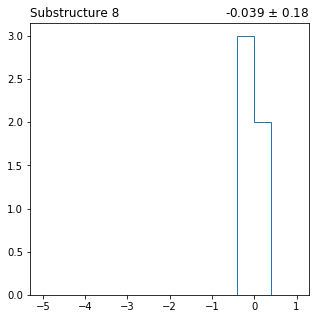

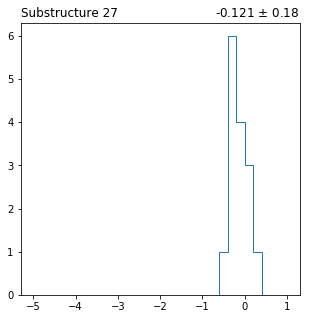

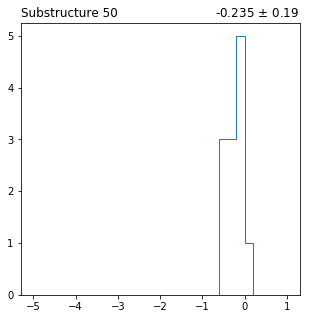

In [547]:
xmin, xmax = -5, 1.2
bins = arange(xmin,xmax,0.2)
n_sub = int(max(ds.data.ext_id[~isnan(ds.data.ext_id)]))

# for n in range(n_sub):
# for n in [2, 7, 9, 24, 34, 39, 46, 63]: # std(Met_K) = 0.2-0.3 dex
for n in [8, 27, 50]: # std(Met_K) < 0.2 dex
    
    fig = p.figure(figsize=(5,5))
    ds.select('ext_id == %s' %n, name='sub')
    
    tmp = ds.evaluate('Met_K', selection='sub')
    tmp = tmp[~isnan(tmp)]
    
    if tmp.std() <= 0.30:

        p.hist(tmp, bins=bins, histtype='step')
        p.title('Substructure %s' %n, loc='left')
        p.title('%s $\pm$ %s' %(round(tmp.mean(), 3), round(tmp.std(), 2)), loc='right')

        p.show()
        p.close()

In [99]:
ds2 = ds.to_copy(column_names=['ext_id', 'Met_K'], selection='ext_id==2')
len(ds)

108916

# 1.1. Random sampling

In [660]:
# how many stars that each substructure have?
nstar = zeros(n_sub)
for n in range(n_sub):
    ds.select('ext_id == %s' %n, name='sub')
    nstar[n] = ds.selected_length(selection='sub')
    print(nstar[n])

10.0
15.0
10.0
10.0
94.0
13.0
74.0
25.0
10.0
17.0
11.0
24.0
11.0
20.0
11.0
30.0
36.0
39.0
24.0
12.0
13.0
17.0
23.0
15.0
13.0
15.0
14.0
15.0
20.0
20.0
24.0
26.0
53.0
31.0
13.0
64.0
92.0
113.0
139.0
20.0
57.0
58.0
54220.0
553.0
26.0
173.0
65.0
958.0
263.0
693.0
12.0
498.0
24.0
527.0
256.0
99.0
45.0
818.0
417.0
40.0
34.0
12.0
13.0
36.0


In [529]:
idx  = 9                  # structure that we want to analyze
size = int(nstar[idx])    # size of random stars used in the sample
loop = 10000              # size of the loop of random sampling

metal = zeros(size)  # provide an array
mean  = zeros(loop)
std   = zeros(loop)

ds.select('ext_id == %s' %idx, name='sub')
tmp = ds.evaluate('Met_K', selection='sub')
tmp = tmp[~isnan(tmp)]
std_sub = tmp.std()

In [530]:
idx, nstar[idx], std_sub

(9, 17.0, 0.21502554)

In [531]:
for j in range(loop):
    
    for i in range(size):
        
        sample   = random.choice(rockstar_id, size=size)
        metal[i] = ds.data.Met_K[ds.data.rockstar_id == sample[i]]
    
#     unknown = len(metal) - len(metal[~isnan(metal)])    # number of stars that have unknown metallicity
#     mean[j] = metal[~isnan(metal)].mean()               # mean and std of the randomly selected stars
    std[j]  = metal[~isnan(metal)].std()

below = round(len(std[std <= std_sub])/len(std)*100, 2)
above = round(len(std[std >  std_sub])/len(std)*100, 2)

print(below, above)

1.37 98.63


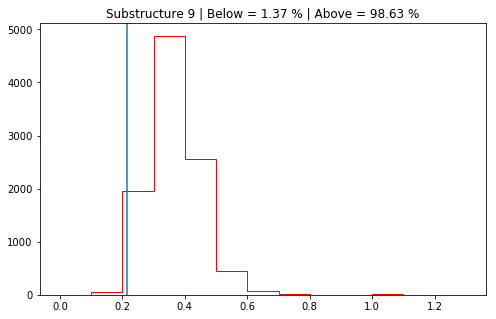

In [664]:
tmp_fig = '/net/virgo01/data/users/virgini/rockstar/RC3/output/std-subs-9.png'

p.figure(figsize=(8,5))
p.hist(std, range=(0, 1.3), bins=13, histtype='step', color='red')
p.axvline(x=std_sub)
p.title('Substructure %s | Below = %s %% | Above = %s %%' %(idx, below, above))
p.savefig(tmp_fig, format='png')
p.show()
p.close()

# Color Magnitude Diagram

In [68]:
# convert apparent magnitude into absolute magnitude
ds.add_column('G', f_or_array=(ds.data.phot_g_mean_mag-(5*log10(ds.data.best_distance*1e3))+5))
ds.add_column('K', f_or_array=(ds.data.Kmag_2MASS-(5*log10(ds.data.best_distance*1e3))+5))

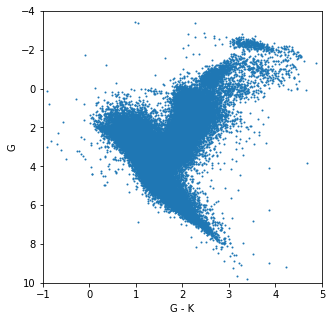

In [775]:
# plot of all stars
p.figure(figsize=(5,5))
ds.scatter('G - K', 'G', s=1, length_check=False)
p.xlim(-1,5), p.ylim(-4, 10)
p.gca().invert_yaxis()

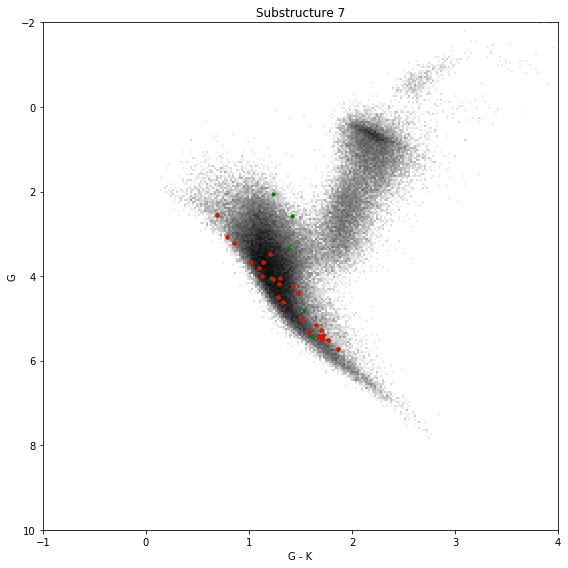

In [783]:
n_sub = int(max(ds.data.ext_id[~isnan(ds.data.ext_id)]))
# for n in range(n_sub):
for n in [7]:
# for n in [2, 7, 9, 24, 34, 39, 46, 63]: # std(Met_K) = 0.2-0.3 dex
# for n in [8, 27, 50]: # std(Met_K) < 0.2 dex
    p.figure(figsize=(8,8))
    ds.select('ext_id == %s' %n, name='sub')
    ds.plot('G - K', 'G', f='log', limits=[[-1,4],[-2,10]], colormap='Greys', colorbar=False)
    ds.scatter('G - K', 'G', s=10, selection='cluster1', c='green')
    ds.scatter('G - K', 'G', s=10, selection='sub', c='red', length_check=False)
    p.title('Substructure %s' %n)
    p.xlim(-1,4), p.ylim(-2, 10)
    p.gca().invert_yaxis()

In [85]:
p.close('all')

In [116]:
tmp_pdf = '/net/virgo01/data/users/virgini/rockstar/RC3/output/vary-fb-10//analyze-high-conf.pdf'

diam = 0.075 #kpc
width = int(diam*2*1e3)

xmin, xmax = -5, 1.2
bins = arange(xmin,xmax,0.2)

with PdfPages(tmp_pdf) as pdf:

    for n in idh:
        
        fig = p.figure(figsize=(14,20))
        gs = p.GridSpec(nrows=3, ncols=2)
        p.suptitle('Substructure %s \n' %int(n), y=0.97, fontsize='xx-large')
        ds.select('sub_id == %s' %n, name='sub')
        
        fig.add_subplot(gs[0,:])
        ds.scatter(x='l', y='b', selection='sub', s=3, length_check=False)
        p.text(10, 75, 'Number of stars : %s' %ds.selected_length('sub'))
        dist = round(ds.evaluate('best_distance', selection='sub').mean(), 2)
        sigm = round(ds.evaluate('best_distance_uncertainty', selection='sub').mean(), 2)
        p.text(10, 65, 'Distance : %s $\pm$ %s kpc' %(dist, sigm))
        gall = round(median(ds.evaluate('l', selection='sub')), 2)
        galb = round(median(ds.evaluate('b', selection='sub')), 2)
        if n == 15:
            gall = round(347.77235278000001, 2)
        p.text(10, 55, 'Median position (l,b) : %s, %s' %(gall, galb))
        p.xlim(0,360)
        p.ylim(-90,90)

        fig.add_subplot(gs[2])
        ds.scatter(x='x', y='y', selection='sub', s=16, length_check=False)  # position
            
        meanx = ds.evaluate('x', selection='sub').mean()                    # center of position
        meany = ds.evaluate('y', selection='sub').mean()
        meanz = ds.evaluate('z', selection='sub').mean()
        p.scatter(x=meanx, y=meany, c='red', s=100, marker='x')  

        tmpx  = ds.evaluate('x', selection='sub')                           # velocity vector
        tmpy  = ds.evaluate('y', selection='sub')
        tmpz  = ds.evaluate('z', selection='sub')
        tmpvx = ds.evaluate('vx', selection='sub') / 2500
        tmpvy = ds.evaluate('vy', selection='sub') / 2500
        tmpvz = ds.evaluate('vz', selection='sub') / 2500
        for j in range(ds.selected_length('sub')):
            p.arrow(tmpx[j], tmpy[j], dx=tmpvx[j], dy=tmpvy[j], width=0, head_width=0.0005, fc='black')

        p.xlabel('x [kpc]', fontsize=12)
        p.ylabel('y [kpc]', fontsize=12)
        p.xlim(meanx-diam, meanx+diam)
        p.ylim(meany-diam, meany+diam)
        p.title('Box size = %s pc x %s pc' %(width, width), loc='left')
        circle_50  = p.Circle((meanx,meany), radius=0.025, ec='red', fc='none', label='50 pc')
        p.gca().add_patch(circle_50)
        circle_100 = p.Circle((meanx,meany), radius=0.050, ec='blue', fc='none', label='100 pc')
        p.gca().add_patch(circle_100)
        p.legend(frameon=False)
        
        fig.add_subplot(gs[3])
        ds.scatter(x='z', y='y', selection='sub', s=16, length_check=False)
            
        p.xlabel('z [kpc]', fontsize=12)
        p.ylabel('y [kpc]', fontsize=12, visible=False)
        p.xlim(meanz-diam, meanz+diam)
        p.ylim(meany-diam, meany+diam)
        circle_50  = p.Circle((meanz,meany), radius=0.025, ec='red', fc='none', label='50 pc')
        p.gca().add_patch(circle_50)
        circle_100 = p.Circle((meanz,meany), radius=0.050, ec='blue', fc='none', label='100 pc')
        p.gca().add_patch(circle_100)
        p.legend(frameon=False)

        p.scatter(x=meanz, y=meany, c='red', s=100, marker='x')
        for j in range(ds.selected_length('sub')):
            p.arrow(tmpz[j], tmpy[j], dx=tmpvz[j], dy=tmpvy[j], width=0, head_width=0.0005, fc='black')
            
        sigvx = ds.evaluate('vx', selection='sub').std()
        sigvy = ds.evaluate('vy', selection='sub').std()
        sigvz = ds.evaluate('vz', selection='sub').std()
            
        p.title('$\sigma_{v_x} = %s$  |  $\sigma_{v_y} = %s$  |  $\sigma_{v_z} = %s $  (km/s)' 
                %(round(sigvx,2), round(sigvy,2), round(sigvz,2)), loc='left')
            
        fig.add_subplot(gs[4])
        tmp = ds.evaluate('Met_K', selection='sub')
        tmp = tmp[~isnan(tmp)]

        p.hist(tmp, bins=bins, histtype='step')
        p.title('Metallicity = %s $\pm$ %s' %(round(tmp.mean(), 3), round(tmp.std(), 2)), loc='left')
        
        fig.add_subplot(gs[5])
        ds.plot('G - K', 'G', f='log', limits=[[-1,4],[-2,10]], colormap='Greys', colorbar=False)
        ds.scatter('G - K', 'G', s=7, selection='sub', c='red', length_check=False)
        p.title('Color Magnitude Diagram')
        p.xlim(-1,4), p.ylim(-2, 10)
        p.gca().invert_yaxis()
        
        fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
        pdf.savefig()

p.close('all')

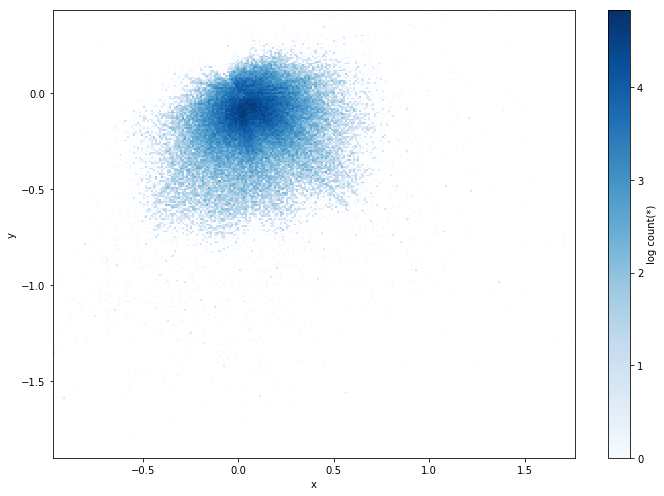

In [720]:
p.figure(figsize=(10,7))
# ds.scatter('x', 'y', s=1, length_check=False)
ds.plot('x', 'y', f='log', limits=None, colormap='Blues', colorbar=True)

In [3]:
fn = "/net/gaia/data/users/breddels/data/tgas/x_rave/tgas_x_rave_more_extra.hdf5"
dd = vaex.open(fn)

In [ ]:
fig = p.figure(figsize=(16,25))

p.subplot(311)
dd.scatter('ra', 'dec', s=1, length_check=False)
p.title('TGAS x RAVE original data set (210263 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
p.tick_params(labelsize='large')
p.xlabel('RA', fontsize='large'), p.ylabel('Dec', fontsize='large')

p.subplot(312)
ds.scatter('ra', 'dec', s=1, length_check=False)
p.title('\nTGAS x RAVE confident data set (108916 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
p.tick_params(labelsize='large')
p.xlabel('RA', fontsize='large'), p.ylabel('Dec', fontsize='large')

p.subplot(313)

n_sub = int(max(ds.data.ext_id[~isnan(ds.data.ext_id)]))
n_500 =[42, 43, 47, 49, 53, 57] #list of indices to be ignored
n_box = [ind for ind in range(n_sub) if ind not in n_500]

ds.scatter('ra', 'dec', s=1, c='lightgray',  length_check=False)
for n in n_box:
# for n in range(n_sub):
    ds.select('ext_id == %s' %n, name='box')
    ds.scatter('ra', 'dec', s=3, selection='box', length_check=False)
p.title('All stars in the substructures (only for n$_*$ < 500) with underlying stars from TGAS x RAVE dataset (grey color)', 
        fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
p.show()

# pdf = PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/Plot all sky.pdf')
# pdf.savefig(fig)
# pdf.close()

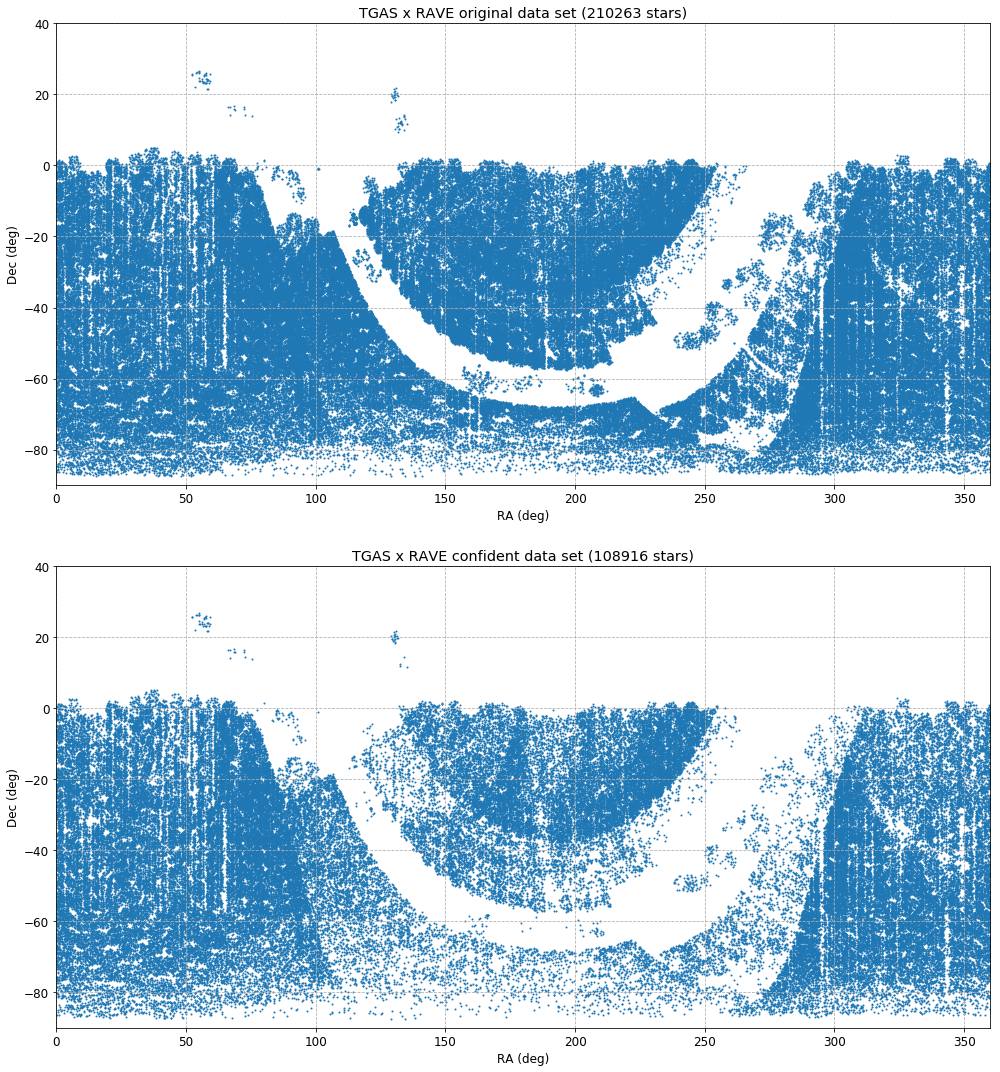

In [27]:
fig = p.figure(figsize=(14,15))

p.subplot(211)
dd.scatter('ra', 'dec', s=1, length_check=False)
p.title('TGAS x RAVE original data set (210263 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
p.tick_params(labelsize='large')
p.xlabel('RA (deg)', fontsize='large'), p.ylabel('Dec (deg)', fontsize='large')

p.subplot(212)
ds.scatter('ra', 'dec', s=1, length_check=False)
p.title('\nTGAS x RAVE confident data set (108916 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,40)
p.tick_params(labelsize='large')
p.xlabel('RA (deg)', fontsize='large'), p.ylabel('Dec (deg)', fontsize='large')

fig.tight_layout()
p.show()
fig.savefig('/net/virgo01/data/users/virgini/rockstar/RC3/output/dataset.png', format='png')

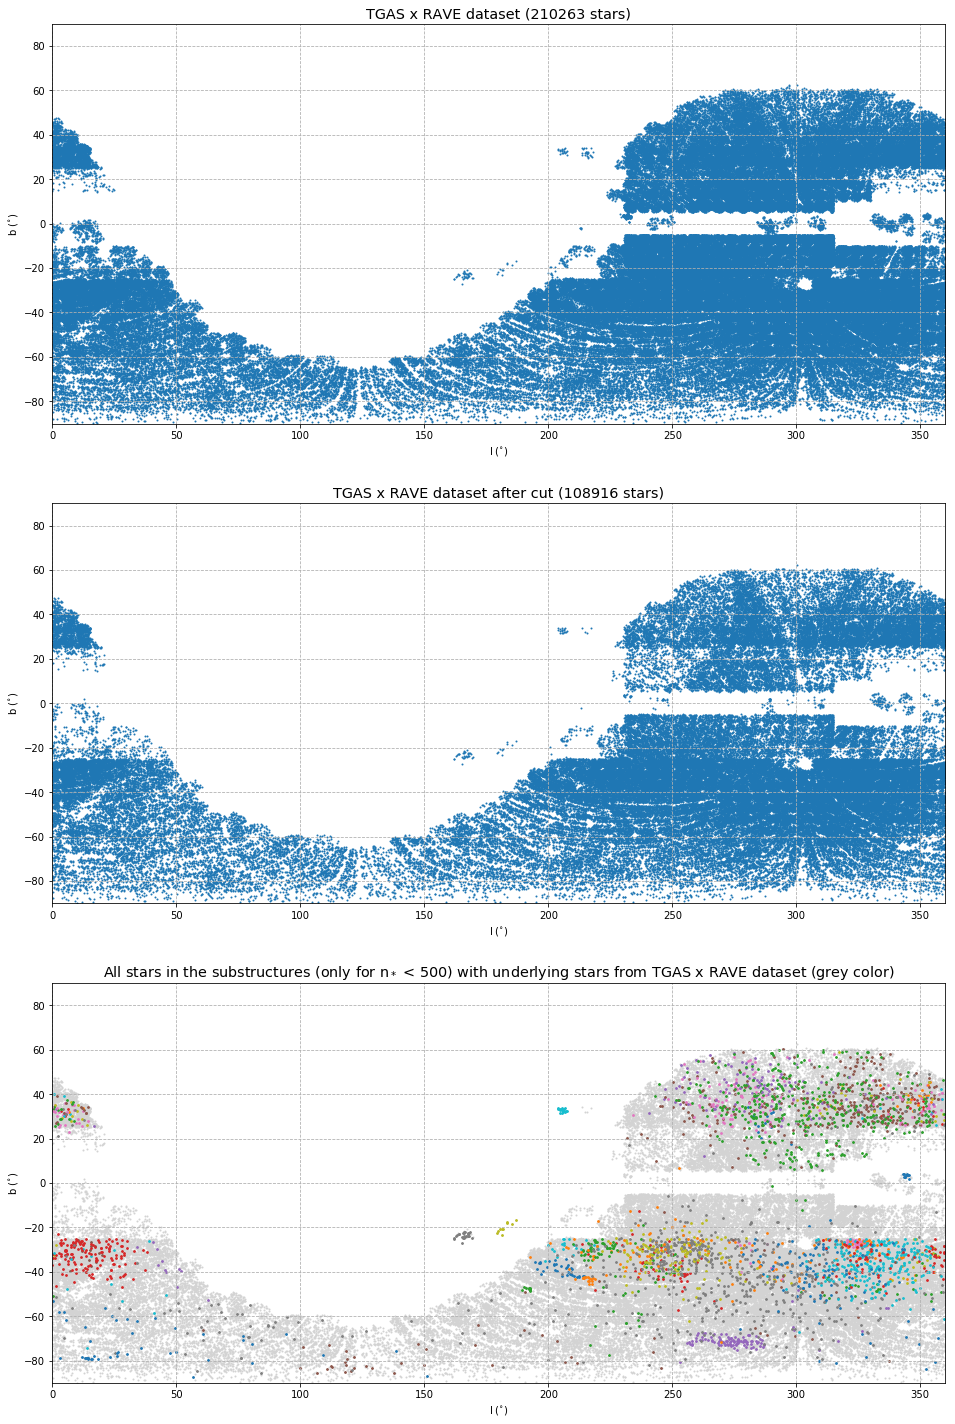

In [860]:
fig = p.figure(figsize=(16,25))

p.subplot(311)
dd.scatter('l', 'b', s=1, length_check=False)
p.title('TGAS x RAVE dataset (210263 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,90)

p.subplot(312)
ds.scatter('l', 'b', s=1, length_check=False)
p.title('TGAS x RAVE dataset after cut (108916 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,90)

p.subplot(313)

n_sub = int(max(ds.data.ext_id[~isnan(ds.data.ext_id)]))
n_500 =[42, 43, 47, 49, 53, 57] #list of indices to be ignored
n_box = [ind for ind in range(n_sub) if ind not in n_500]

ds.scatter('l', 'b', s=1, c='lightgray',  length_check=False)
for n in n_box:
# for n in range(n_sub):
    ds.select('ext_id == %s' %n, name='box')
    ds.scatter('l', 'b', s=3, selection='box', length_check=False)
p.title('All stars in the substructures (only for n$_*$ < 500) with underlying stars from TGAS x RAVE dataset (grey color)', 
        fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(0,360), p.ylim(-90,90)

p.show()

pdf = PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/Plot all sky (l-b).pdf')
pdf.savefig(fig)
pdf.close()

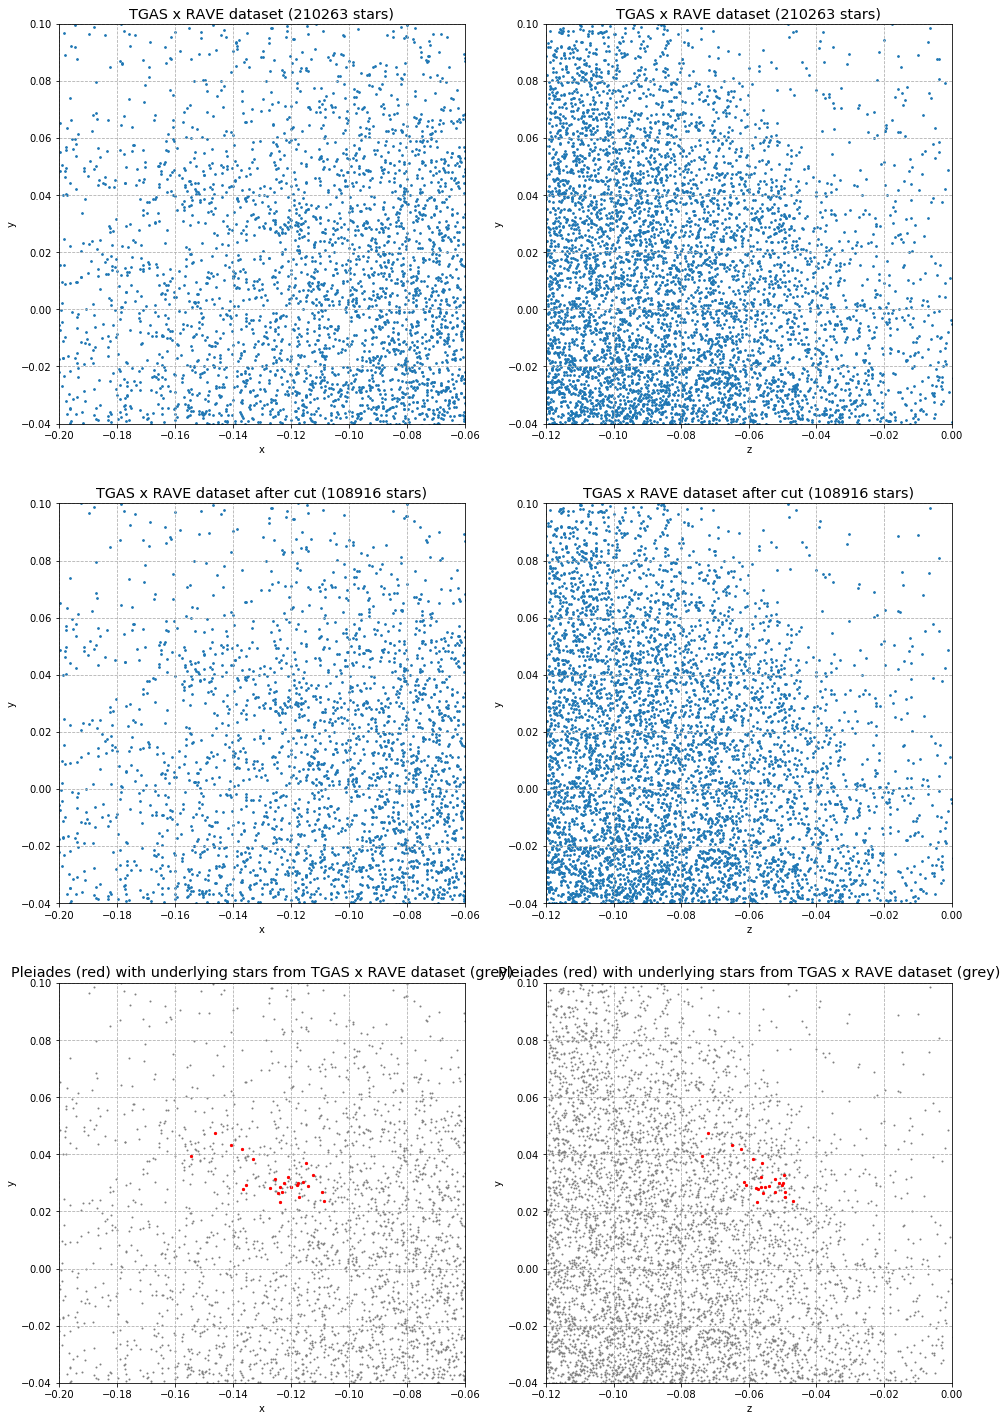

In [888]:
fig = p.figure(figsize=(16,25))

p.subplot(321)
dd.scatter('x', 'y', s=3, length_check=False)
p.title('TGAS x RAVE dataset (210263 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(-0.20,-0.06), p.ylim(-0.04,0.10)

p.subplot(322)
dd.scatter('z', 'y', s=3, length_check=False)
p.title('TGAS x RAVE dataset (210263 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(-0.12,0.0), p.ylim(-0.04,0.10)

p.subplot(323)
ds.scatter('x', 'y', s=3, length_check=False)
p.title('TGAS x RAVE dataset after cut (108916 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(-0.20,-0.06), p.ylim(-0.04,0.10)

p.subplot(324)
ds.scatter('z', 'y', s=3, length_check=False)
p.title('TGAS x RAVE dataset after cut (108916 stars)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(-0.12,0.0), p.ylim(-0.04,0.10)

p.subplot(325)
ds.scatter('x', 'y', s=1, c='gray',  length_check=False)
ds.scatter('x', 'y', s=5, c='red', selection='ext_id==7')
p.title('Pleiades (red) with underlying stars from TGAS x RAVE dataset (grey)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(-0.20,-0.06), p.ylim(-0.04,0.10)

p.subplot(326)
ds.scatter('z', 'y', s=1, c='gray',  length_check=False)
ds.scatter('z', 'y', s=5, c='red', selection='ext_id==7')
p.title('Pleiades (red) with underlying stars from TGAS x RAVE dataset (grey)', fontsize='x-large')
p.grid(linestyle='dashed')
p.xlim(-0.12,0.0), p.ylim(-0.04,0.10)


p.show()

pdf = PdfPages('/net/virgo01/data/users/virgini/rockstar/RC3/output/Plot Pleiades (x-y-z).pdf')
pdf.savefig(fig)
pdf.close()

In [ ]:
p.figure(figsize=(16,8))
ds.select('(dec > 20) & (dec < 40) & (ra > 50) & (ra < 80)', name='cluster1')
ds.select('(dec > 10) & (dec < 20) & (ra > 50) & (ra < 100)', name='cluster2')
# ds.scatter('l', 'b', s=1, c='grey', length_check=False)
ds.scatter('l', 'b', s=25, selection='cluster1')
ds.scatter('l', 'b', s=3, selection='cluster2')
p.xlim(0,360), p.ylim(-90,90)
ds.scatter('l', 'b', s=5, c='red', selection='ext_id==7')
# p.xlim(150,180), p.ylim(-10,-30)
p.show()

In [759]:
ds.selected_length(selection='cluster1'), ds.selected_length(selection='ext_id == 7')

(31, 25)

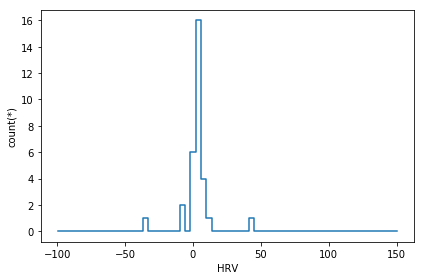

In [764]:
ds.plot1d('HRV', selection='cluster1')

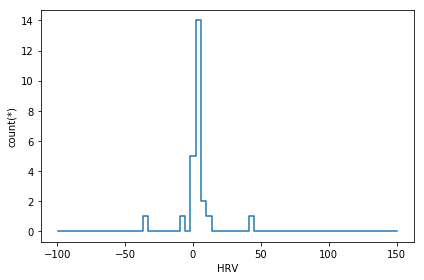

In [765]:
ds.plot1d('HRV', selection='ext_id==7')

In [767]:
ds.to_pandas_df(column_names=['vx', 'HRV'], selection='cluster1')
ds.evaluate('sqrt((vx**2+vy**2+vz**2)/3)', selection='cluster1').std()

3.7961996333826891

In [763]:
ds.to_pandas_df(column_names=['vx', 'HRV'], selection='ext_id==7')

,HRV,vx
0,0.593000,-2.394905
1,3.654000,-3.612174
2,3.035000,-4.105905
3,4.336000,-5.596469
4,1.399000,-2.561320
5,2.630000,-4.518380
6,4.093000,-5.216938
7,5.717000,-6.563896
8,6.760000,-7.729174
9,44.166000,-42.669037


# Cross match to open cluster catalogue DAML02 (22/08/2017)

1. Get table from DAML02, upload to X-Match in CDS website
2. Get table from ROCKSTAR. The halo table contains xyz position, but we need RA and Dec. Thus we will use the Particle table and then calculate the mean or median position in RA and Dec for each substructure. Then upload to X-Match in CDS.

In [13]:
# the original dataset (ds = dataset of the original tgas-rave)
tmp_data = '/net/virgo01/data/users/virgini/rockstar/RC3/data/data_6d_cut'
ds = vaex.open(tmp_data)

# the output from rockstar (dp = dataset of particles)
tmp_part = '/net/virgo01/data/users/virgini/rockstar/RC3/output/b05-f40-n10-t70-particles'
hdr_part = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'rs_id', 'as_int_id', 'int_id', 'ext_id']
dp = vaex.from_ascii(tmp_part, names=hdr_part)

# convert the data from integer into float
dp.add_column(name='as_int_id', data=dp.data.as_int_id.astype(float))
dp.add_column(name='int_id', data=dp.data.int_id.astype(float))
dp.add_column(name='ext_id', data=dp.data.ext_id.astype(float))

# select only the real substructures
dp.select('(as_int_id == int_id) & (ext_id != -1)', name='real')
dp_sel = dp.to_copy(selection='real')

# join the 2 datasets
ds._join('rockstar_id', dp_sel, 'rs_id', column_names=['as_int_id', 'int_id', 'ext_id'])
dj = ds

In [7]:
output = '/net/virgo01/data/users/virgini/rockstar/RC3/output/cluster-1'

# write the header in the file
with open(output, 'w') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    writer.writerow(['#Sub_ID', 'RA', 'Dec'])
    f.close()

# write the data in the file
with open(output, 'a') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    n_sub = int(max(ds.data.ext_id[~isnan(ds.data.ext_id)]))
    for n in range(n_sub):
        ds.select('ext_id == %s' %n, name='sub')
        ra  = median(ds.evaluate('ra', selection='sub'))
        dec = median(ds.evaluate('dec', selection='sub'))        
        writer.writerow([n, ra, dec])
    f.close()

# Cross match between Rockstar and DAML02 (23/08/2017)

1. Calculate the expansion of the substructures on the sky (RA, Dec)
2. Decide the maximum offset (10% of the expansion on the sky)
3. Do cross match with DAML02 using intersect1d

In [123]:
tmp_out = '/net/virgo01/data/users/virgini/rockstar/RC3/output/cluster-1'
hdr_out = ['sub_id', 'ra', 'dec']
dc = vaex.from_ascii(tmp_out, seperator=',', names=hdr_out) #data set of rockstar cluster

The calculation of the median RA and Dec is not always true, since there might be some substructures that are in the edge of 0 and 360 degree. Maybe we can check this by plotting the whole substructure and then make a point of the median position? And so we can manually check.

In [ ]:
n_sub = int(max(ds.data.ext_id[~isnan(ds.data.ext_id)]))
for n in range(n_sub):
    p.figure(figsize=(14,7))
    dj.scatter('ra', 'dec', s=3, selection='ext_id == %s' %n)
    dc.scatter('ra', 'dec', s=3, c='red', selection='sub_id == %s' %n)
    p.xlim(0,360), p.ylim(-90,40)
    p.show()

Turns out it's okay. For the first experiment, only about 5 substructures have median position not accurate.

Now for every substructure, calculate the span on the sky in RA and Dec.

In [ ]:
# call the DAML table

tmp_daml = '/net/virgo01/data/users/virgini/rockstar/RC3/output/cluster-1'
hdr_out = ['sub_id', 'ra', 'dec']
dc = vaex.from_ascii(tmp_out, seperator=',', names=hdr_out) #data set of rockstar cluster

In [129]:
n_sub = int(max(dj.data.ext_id[~isnan(dj.data.ext_id)]))
for n in [0]: #range(n_sub):
    
    # select substructure
    dj.select('ext_id == %s' %n, name='sub')
    
    # calculate median of position on the sky
    ra_med  = median(ds.evaluate('ra', selection='sub'))
    dec_med = median(ds.evaluate('dec', selection='sub'))     
    
    # calculate the spand on the sky
    ra_max = dj.evaluate('ra', selection='sub').max()
    ra_min = dj.evaluate('ra', selection='sub').min()
    ra_spand = ra_max - ra_min
    dec_max = dj.evaluate('dec', selection='sub').max()
    dec_min = dj.evaluate('dec', selection='sub').min()
    dec_spand = dec_max - dec_min
    
    # calculate the offset
    ra_offset = 0.1*ra_spand
    dec_offset = 0.1*dec_spand
    
    # calculate the range of offset (can go up and down, left and right from the median position)
    ra_offset_max = ra_med + ra_offset
    ra_offset_min = ra_med - ra_offset
    dec_offset_max = dec_med + dec_offset
    dec_offset_min = dec_med - dec_offset
    
    if ra_offset_min <= coba <= ra_offset_max:
        print('yes')

yes


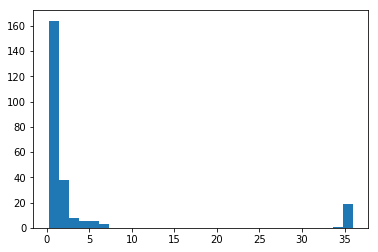

In [97]:
p.hist(ra_offset_array, bins=30)
p.show()

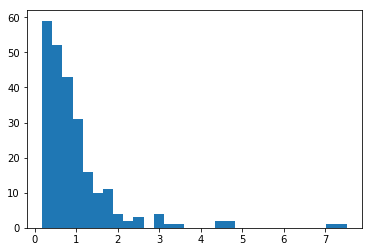

In [98]:
p.hist(dec_offset_array, bins=30)
p.show()

In [110]:
for i in range(5):
    n = ds.data.ra[i]
    if n in range(0, 101):
        print('yes')

In [107]:
n = float(input("enter a number between 0 and 100: "))
if 0 <= n <= 100:
  print('yes')

enter a number between 0 and 100: 54.56
yes


In [112]:
ra_spand, dec_spand

(5.1062888992880744, 3.6707994930797412)

In [122]:
n = 3.6
if dec_spand <= n <= ra_spand:
    print('yes')